# Определение возраста покупателей

# Описание проекта:

**Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:** </br>

- **Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы.**
- **Контролировать добросовестность кассиров при продаже алкоголя.**

**Требуется построить модель, которая по фотографии определит приблизительный возраст человека. В качестве данных предоставлен набор фотографий с указанием реального возраста людей.**

**Предстоит решать задачу регрессии, т.к. возраст - это количественный признак, с метрикой качества MAE не больше 8 (из пожелания заказчика).**

**Для построения модели будем использовать предобученную нейросеть ResNet50 с заменой последнего слоя на адаптированный под нашу задачу.**


## Исследовательский анализ данных

In [2]:
# импорт библиотек из директорий:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

Не показан импорт рабочего датасета из требования конфиденциальности ЯП.

In [6]:
# состав изображения:
features_train, target_train = next(data)
print(features_train.shape)

(32, 224, 224, 3)


In [7]:
# внешний вид датасета с метками возраста:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


**Из описания данных видим, что минимальный возраст - 1 год, максимальный-100 лет. 50% людей имеют возраст 29 лет. А средний возраст в выборке 31 год.**

### график распределения возраста

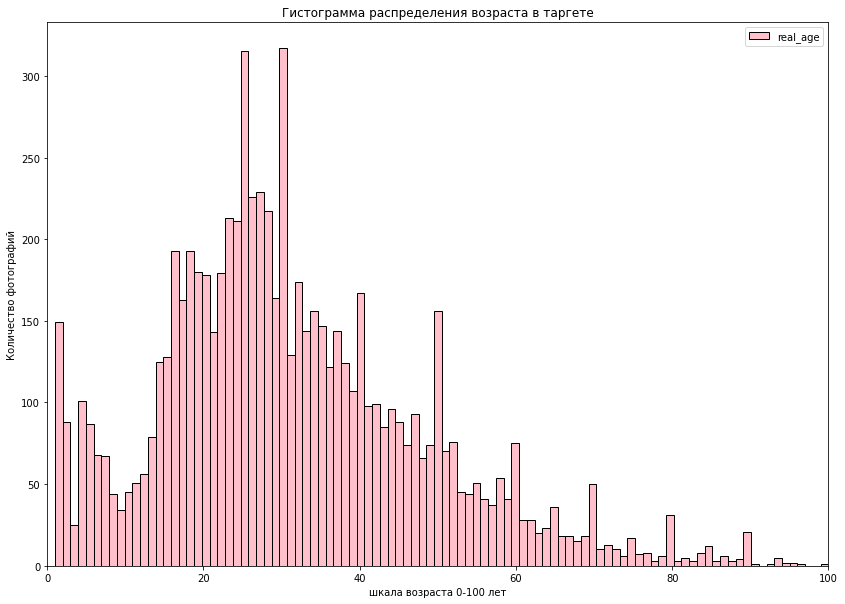

In [6]:
ax = labels.plot(kind='hist',
            bins=100,
            figsize=(14, 10),
            xlim=(0, 100),
            color='pink',
            edgecolor='black',
            title='Гистограмма распределения возраста в таргете')
ax.set_xlabel('шкала возраста 0-100 лет')
ax.set_ylabel('Количество фотографий')
plt.show();

### вывод первых изображений

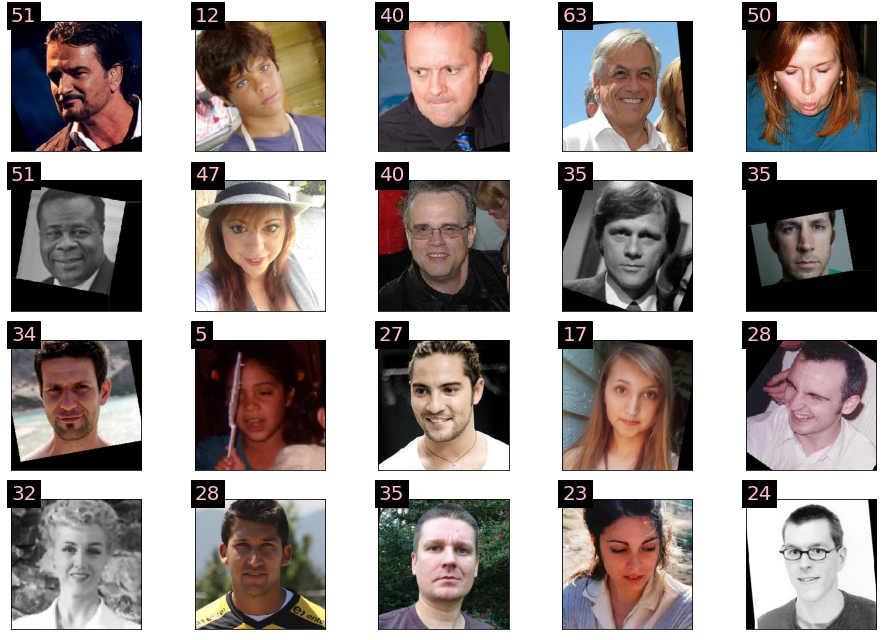

In [7]:
image, age = next(train_datagen)
fig = plt.figure(figsize=(14, 9))
for index in range(20):
    ax = fig.add_subplot(4,
                         5,
                         index + 1)
    plt.imshow(image[index])
    plt.text(0,
             0,
             age[index],
             fontsize = 20, 
             color='pink',
             backgroundcolor='black')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод:**
- В датасете 7591 фото, что достаточно для обучения модели регрессии, при необходимости можно будет применить аугментацию.
- Фото являются цветными, содержат 32 фотографии в батче и все приведены к размеру 224х224, что является стандартным для применения алгоритма ResNet50.
- На некоторых фото видны аномалии.
- Гистограмма распределения возраста похожа на нормальное с пиками почти через каждые 10 лет. Возможно это связано с округлением возраста при разметке, т.к. люди склонны округлять возраст до ближайшего круглого значения.
- Малое количество данных для определенной категории (в данном случае для пожилых людей) может привести к смещению модели в сторону более представленных категорий (20-40 лет). Кроме того, модель может обучиться на основе характеристик данных категорий, которые не будут работать для других возрастов, что также может привести к низкому качеству предсказаний.


## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

### загрузка данных

Будем использовать следующие аугментации в обучающей выборке:

- Вертикальный флип
- Шифт по вертикали и горизонтали до 15%
- Рандомный зум до 10%

```python

# загрузим тренировочную выборку:

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')

    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.,
        vertical_flip=True,
        width_shift_range=0.150,
        height_shift_range=0.150,
        zoom_range=0.1,
    )

    return datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345,
    )

```

```python

# загрузим тестовую выборку:
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')

    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.)

    return datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345,
    )
```

### применение архитектуры Backbone ResNet50 совместно с заморозкой слоев

```python
# модель ResNet50 с активацией relu на последнем полносвязном слое(Dense):
def create_model(input_shape):
    backbone = ResNet50(weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        input_shape=input_shape, 
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='mean_squared_error', metrics=['mean_absolute_error'])

    return model

# по условию задачи функция train_model должна иметь следующие аргументы (model, train_data, 
# test_data, batch_size, epochs, steps_per_epoch, validation_steps) 

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              epochs=epochs, 
              batch_size=batch_size,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, 
              shuffle=True)

    return model
```


### результат обучения модели на сервере GPU

```

Train for 178 steps, validate for 60 steps
Epoch 1/10
2023-09-16 13:40:34.381001: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-09-16 13:40:34.861708: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 108s - loss: 279.0017 - mean_absolute_error: 12.3212 - val_loss: 823.2129 - val_mean_absolute_error: 23.7952
Epoch 2/10
178/178 - 101s - loss: 110.8051 - mean_absolute_error: 7.9634 - val_loss: 877.3198 - val_mean_absolute_error: 24.7417
Epoch 3/10
178/178 - 101s - loss: 92.6991 - mean_absolute_error: 7.2638 - val_loss: 322.4223 - val_mean_absolute_error: 13.3782
Epoch 4/10
178/178 - 100s - loss: 71.6147 - mean_absolute_error: 6.5275 - val_loss: 151.3073 - val_mean_absolute_error: 9.1750
Epoch 5/10
178/178 - 101s - loss: 62.4003 - mean_absolute_error: 6.0656 - val_loss: 96.8434 - val_mean_absolute_error: 7.4367
Epoch 6/10
178/178 - 99s - loss: 54.1063 - mean_absolute_error: 5.6330 - val_loss: 88.0599 - val_mean_absolute_error: 7.2488
Epoch 7/10
178/178 - 100s - loss: 47.3886 - mean_absolute_error: 5.2536 - val_loss: 91.5788 - val_mean_absolute_error: 7.4422
Epoch 8/10
178/178 - 101s - loss: 43.2984 - mean_absolute_error: 5.0607 - val_loss: 90.8259 - val_mean_absolute_error: 7.0465
Epoch 9/10
178/178 - 97s - loss: 38.0387 - mean_absolute_error: 4.7513 - val_loss: 133.8206 - val_mean_absolute_error: 8.5392
Epoch 10/10
178/178 - 101s - loss: 34.2387 - mean_absolute_error: 4.5080 - val_loss: 93.6783 - val_mean_absolute_error: 6.9982
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 11s - loss: 93.6783 - mean_absolute_error: 6.9982
Test MAE: 6.9982
```

## Анализ обученной модели

- Модель построена с помощью предобученной ResNet50 с полносвязым слоем Dense(1) с активацией `relu`.
- Получено MAE на тестовой выборке 6.99, что меньше заданного 8, при оптимайзере `Adam` с learning_rate = 0.0001.
- Видно, что достаточная метрика MAE фактически была достигнута на 6 эпохе.
- C учетом полученных результатов можно рекомендовать использовать данную млдель для выполнения первой поставленной задачи --анализировать покупки и предлагать товары, которые могут заинтересовать покупателей определенной возрастной группы при предварительной категоризации потенциальных покупателей на, например, следующие возрастные категории: 
- дети;
- юноши;
- молодые люди;
- покупатели среднего возраста;
- пожилые.

Что касается второй задачи — контролировать добросовестность кассиров при продаже алкоголя — с учетом полученного MAE, модель не покажет хороших результатов на практике.


